# Importing necessary Libraries and Modules

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
from google.colab import drive
from torchvision.datasets.utils import download_url
import pickle as pkl
import random
import os

In [ ]:
drive.mount

<function google.colab.drive.mount>

# Mounting GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Defining Model

In [ ]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    conv=nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers=[]
    transpose_conv=nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)

    layers.append(transpose_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*4,4,batch_norm=False)
        self.conv4=conv(conv_dim*4,conv_dim*8,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*8*2*2,1)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*8*2*2)
        out=self.fc(x)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        self.conv_dim=conv_dim
        self.fc = nn.Linear(z_size,conv_dim*8*2*2)

        self.deconv1 = deconv(conv_dim*8,conv_dim*4,4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv3 = deconv(conv_dim*2,conv_dim,4)
        self.deconv4 = deconv(conv_dim,3,4,batch_norm=False)

    def forward(self,x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.deconv4(x)
        out = F.tanh(x)
        return out

In [ ]:
def weights_init_normal(m):

    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

z_size=100
image_size=32
D=Discriminator(image_size)
G=Generator(z_size,image_size)

D.apply(weights_init_normal),G.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    D.cuda()
    G.cuda()

print(f"{D}\n\n\n{G}\n\n\nGPU on:{use_cuda and torch.cuda.is_available()}")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)


Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [ ]:
class Encoder(nn.Module):
    def __init__(self,conv_dim, z_size):
        super(Encoder,self).__init__()
        self.conv_dim=conv_dim

        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4,batch_norm=False)
        self.conv3=conv(conv_dim*2,conv_dim*4,4,batch_norm=False)
        self.conv4=conv(conv_dim*4,conv_dim*8,4,batch_norm=False)

        self.fc=nn.Linear(conv_dim*8*2*2,z_size)


    def forward(self,x):
        x=F.leaky_relu(self.conv1(x),0.2)
        x=F.leaky_relu(self.conv2(x),0.2)
        x=F.leaky_relu(self.conv3(x),0.2)
        x=F.leaky_relu(self.conv4(x),0.2)
        x = x.view(-1, self.conv_dim*8*2*2)
        out=self.fc(x)
        return out

In [ ]:
E = Encoder(image_size, z_size)
E.apply(weights_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
    E.cuda()

In [ ]:
E

Encoder(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=1024, out_features=100, bias=True)
)

In [ ]:
e_optimizer = optim.Adam(E.parameters(),lr=0.0002,betas=(0.5,0.999))

# Checkpoint Loading for Generator

In [ ]:
def save_checkpoint(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'gen': G.state_dict(), 'disc': D.state_dict(), 'optim_d': d_optimizer.state_dict(), 'optim_g':g_optimizer.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth'))

def load_checkpoint(G1, D1, d_optimizer1, g_optimizer1):
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_dcgan.pth'))
  G1.load_state_dict(dic['gen'])
  D1.load_state_dict(dic['disc'])
  d_optimizer1.load_state_dict(dic['optim_d'])
  g_optimizer1.load_state_dict(dic['optim_g'])
  return dic['e']

In [ ]:
path_to_checkpoint = '/content/drive/MyDrive/WiDS_Controllable_Image_Generation'
d_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
g_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
load_checkpoint(G, D, d_optimizer, g_optimizer)

50

# Helper Functions

In [ ]:
# Helper Functions

def pairwise_euclidean(samples):

    B = samples.size(0)

    samples_norm = samples.mul(samples).sum(1)
    samples_norm = samples_norm.expand(B, B)

    dist_mat = samples.mm(samples.t()).mul(-2) + \
        samples_norm.add(samples_norm.t())
    return dist_mat


def sample_entropy(samples):

        # Assume B x C input

    dist_mat = pairwise_euclidean(samples)

    # Get max and add it to diag
    m = dist_mat.max().detach()
    dist_mat_d = dist_mat + \
        Variable(torch.eye(dist_mat.size(0)) * (m.data[0] + 1)).cuda()

    entropy = (dist_mat_d.min(1)[0] + 1e-4).log().sum()

    entropy *= (samples.size(1) + 0.) / samples.size(0)

    return entropy


class SampleKLN01Loss(torch.nn.Module):

    def __init__(self, direction, minimize):
        super(SampleKLN01Loss, self).__init__()
        self.minimize = minimize
        assert direction in ['pq', 'qp'], 'direction?'

        self.direction = direction

    def forward(self, samples):

        assert samples.ndimension == 2, 'wft'
        samples = samples.view(samples.size(0), -1)

        self.samples_var = var(samples)
        self.samples_mean = samples.mean(0)

        if self.direction == 'pq':
            assert False, 'not possible'
        else:
            entropy = sample_entropy(samples)

            cross_entropy = - samples.pow(2).mean() / 2.

            KL = - cross_entropy - entropy

        if not self.minimize:
            KL *= -1

        return KL


def match(x, y, dist):
    '''
    Computes distance between corresponding points points in `x` and `y`
    using distance `dist`.
    '''
    if dist == 'L2':
        return (x - y).pow(2).mean()
    elif dist == 'L1':
        return (x - y).abs().mean()
    elif dist == 'cos':
        x_n = normalize(x)
        y_n = normalize(y)

        return 2 - (x_n).mul(y_n).mean()
    else:
        assert dist == 'none', 'wtf ?'

# Setting Hyper Parameters

In [ ]:
# Parameters
image_size = 32   #Can change depending on dataset 
z_size=100
num_channel = 3
sample_size=16
match_x = 'L1'
match_z = 'cos'
n_epochs = 50
batch_size = 16

# Trash (ignore)

In [ ]:
# x = torch.FloatTensor(sample_size, num_channel, image_size, image_size)
# z = torch.FloatTensor(sample_size, z_size)
# fixed_z = torch.FloatTensor(sample_size, z_size).normal_(0, 1)

fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
# move z to GPU if available
if use_cuda and torch.cuda.is_available():
    fixed_z = fixed_z.cuda()


# if use_cuda and torch.cuda.is_available():
#     E.cuda()
#     G.cuda()
#     x = x.cuda()
#     z, fixed_z = z.cuda(), fixed_z.cuda()



# stats = {}

# for epoch in range(n_epochs):
#     # # X
#     # populate_x(x, dataloader['train'])
#     # e(X)
#     ex = netE(x)
#     # KL_real: - \Delta( e(X) , Z ) -> max_e
#     KL_real = KL_minimizer(ex)
#     e_losses.append(KL_real * updates['e']['KL_real'])

#     # if updates['e']['match_x'] != 0:
#     # g(e(X))
#     gex = netG(ex)
#     # match_x: E_x||g(e(x)) - x|| -> min_e
#     err = match(gex, x, match_x)
#     e_losses.append(err)

#     # Save some stats
#     stats['real_mean'] = KL_minimizer.samples_mean.data.mean()
#     stats['real_var'] = KL_minimizer.samples_var.data.mean()
#     stats['KL_real'] = KL_real.data[0]
    
#     ################### Work from here onwards
#     # # Z
#     # populate_z(z, opt)
#     # g(Z)
#     fake = netG(z).detach()
#     # e(g(Z))
#     egz = netE(fake)

#     # KL_fake: \Delta( e(g(Z)) , Z ) -> max_e
#     KL_fake = KL_maximizer(egz)
#     e_losses.append(KL_fake)       #  * updates['e']['KL_fake']

#     if updates['e']['match_z'] != 0:
#         # match_z: E_z||e(g(z)) - z|| -> min_e
#         err = match(egz, z, opt.match_z)
#         e_losses.append(err * updates['e']['match_z'])

#     # Save some stats
#     stats['fake_mean'] = KL_maximizer.samples_mean.data.mean()
#     stats['fake_var'] = KL_maximizer.samples_var.data.mean()
#     stats['KL_fake'] = -KL_fake.data[0]

#     # Update e
#     sum(e_losses).backward()
#     optimizerD.step()



In [ ]:
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z.shape

torch.Size([16, 100])

In [ ]:
KL_minimizer = SampleKLN01Loss('qp' ,minimize=True)
KL_maximizer = SampleKLN01Loss('qp' ,minimize=False)

In [ ]:
KL_minimizer

SampleKLN01Loss()

# Generator Image Prereview

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


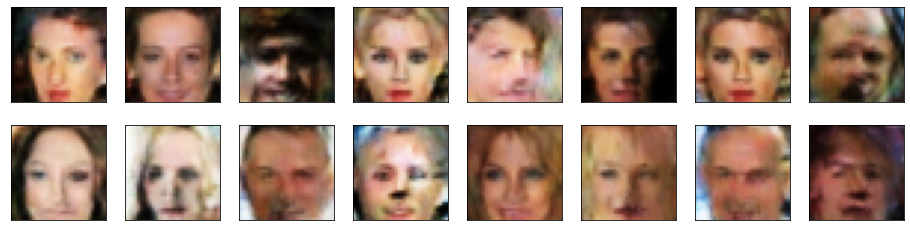

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

# Generate fake images
batch_size = 16
z = np.random.uniform(-1, 1, size=(batch_size, z_size))
z = torch.from_numpy(z).float()
if use_cuda and torch.cuda.is_available():
    z = z.cuda()
fake_images = G(z)

view_samples(0, [fake_images])

# Perceptual Loss

In [ ]:
class Vgg16(nn.Module):
	def __init__(self):
		super(Vgg16, self).__init__()
		features = models.vgg16(pretrained=True).features
		self.to_relu_1_2 = nn.Sequential()
		self.to_relu_2_2 = nn.Sequential()
		self.to_relu_3_3 = nn.Sequential()
		self.to_relu_4_3 = nn.Sequential()

		for x in range(4):
			self.to_relu_1_2.add_module(str(x), features[x])
		for x in range(4, 9):
			self.to_relu_2_2.add_module(str(x), features[x])
		for x in range(9, 16):
			self.to_relu_3_3.add_module(str(x), features[x])
		for x in range(16, 23):
			self.to_relu_4_3.add_module(str(x), features[x])

		# don't need the gradients, just want the features
		for param in self.parameters():
			param.requires_grad = False

	def forward(self, x):
		h = self.to_relu_1_2(x)
		h_relu_1_2 = h
		h = self.to_relu_2_2(h)
		h_relu_2_2 = h
		h = self.to_relu_3_3(h)
		h_relu_3_3 = h
		h = self.to_relu_4_3(h)
		h_relu_4_3 = h
		out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
		return out

In [ ]:
def gram(x):
	(bs, ch, h, w) = x.size()
	f = x.view(bs, ch, w*h)
	f_T = f.transpose(1, 2)
	G = f.bmm(f_T) / (ch * h * w)
	return G

def perceptual_loss(vgg, batch, logit):
  data_features = vgg(batch)
  logit_features = vgg(logit)
  data_feature_gram = [gram(fmap) for fmap in data_features]
  logit_feature_gram = [gram(fmap) for fmap in logit_features]

  p_loss_vgg = torch.zeros(batch.size(0)).cuda()
  for idx in range(4):
    N = torch.Tensor([data_feature_gram[idx].size(1) * data_feature_gram[idx].size(2)]).cuda()
    diff = (data_feature_gram[idx] - logit_feature_gram[idx]).cuda()
    p_loss_vgg += torch.sum(diff.pow(2), [1, 2]) * N
  return p_loss_vg #lotit*batchsize


dtype = torch.cuda.FloatTensor
vgg = Vgg16().type(dtype)

# Loading Encoder Checkpoints (if any)

In [ ]:
path_to_checkpoint = '/content/drive/MyDrive/WiDS_Controllable_Image_Generation'

def save_checkpoint_encoder(e):
  if not os.path.isdir(path_to_checkpoint):
    os.mkdir(path_to_checkpoint)
  torch.save({'e':e,'enc': E.state_dict(), 'optim_e': e_optimizer.state_dict()}, os.path.join(path_to_checkpoint, 'checkpoint_encoder.pth'))

def load_checkpoint_encoder(E1, e_optimizer1):
  if not os.path.isfile(os.path.join(path_to_checkpoint, 'checkpoint_encoder.pth')):
    return -1
  dic = torch.load(os.path.join(path_to_checkpoint, 'checkpoint_encoder.pth'))
  E1.load_state_dict(dic['enc'])
  e_optimizer1.load_state_dict(dic['optim_e'])
  return dic['e']

In [ ]:
load_checkpoint_encoder(E, e_optimizer)

2500

# Training the Encoder

In [ ]:
# Function to fix the seed for randomisation
def fix_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(88)

In [ ]:
"""
What steps to cover? :
z
x_n = G(z)
z_n = E(x_n)
x_rec = G(z_n)
loss = ||x_n - x_rec||
update parameters
"""

#For keeping track
fixed_G_sample = []
fixed_E_sample = []
losses = []

data_size = 10000
z_data = np.random.uniform(-1, 1, size=(data_size, z_size))
z_data = torch.from_numpy(z_data).float()
# if use_cuda and torch.cuda.is_available():
#   z = z.cuda()

onetime_train_size = 16
tmp = torch.split(z_data, onetime_train_size)
z_data = tmp


def train(E, G, n_epochs):

    # move models to GPU
    if use_cuda and torch.cuda.is_available():
        D.cuda()
        E.cuda()

    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if use_cuda and torch.cuda.is_available():
        fixed_z = fixed_z.cuda()


    # fixed_G_sample = []
    # fixed_E_sample = []
    # losses = []


    for epoch in range(n_epochs):

        for z in z_data:

            # z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            # z = torch.from_numpy(z).float()
            # if use_cuda and torch.cuda.is_available():
            #   z = z.cuda()

            if use_cuda and torch.cuda.is_available():
                z = z.cuda()

            x_n = G(z)
            z_n = E(x_n)
            x_rec = G(z_n)

            # loss = ||x_n - x_rec||
            e_loss = perceptual_loss(vgg, x_n, x_rec).mean()

            # update parameters of E
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

        losses.append(e_loss)

        x_n = G(fixed_z)    
        fixed_G_sample.append(x_n)

        z_n = E(x_n)
        x_rec = G(z_n)
        fixed_E_sample.append(x_rec)

        if(epoch%10 == 0):
            save_checkpoint_encoder(e=epoch)

        print('Epoch [{:5d}/{:5d}] | perceptual_loss: {:6.4f}'.format(
        epoch+1, n_epochs, e_loss.item()))


    with open('train_G_samples.pkl', 'wb') as f:
        pkl.dump(fixed_G_sample, f)

    with open('train_E_samples.pkl', 'wb') as f:
        pkl.dump(fixed_E_sample, f)

    return losses
        

In [ ]:
n_epochs = 200
# call training function
losses = train(E, G, n_epochs=n_epochs)
save_checkpoint_encoder(e=3000)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  200] | perceptual_loss: 374184.0000
Epoch [    2/  200] | perceptual_loss: 280417.8125
Epoch [    3/  200] | perceptual_loss: 240185.6406
Epoch [    4/  200] | perceptual_loss: 213561.4375
Epoch [    5/  200] | perceptual_loss: 204479.6250
Epoch [    6/  200] | perceptual_loss: 195831.9844
Epoch [    7/  200] | perceptual_loss: 177700.6562
Epoch [    8/  200] | perceptual_loss: 187629.9375
Epoch [    9/  200] | perceptual_loss: 161745.5625
Epoch [   10/  200] | perceptual_loss: 168281.1875
Epoch [   11/  200] | perceptual_loss: 159678.4844
Epoch [   12/  200] | perceptual_loss: 166664.7344
Epoch [   13/  200] | perceptual_loss: 143045.1094
Epoch [   14/  200] | perceptual_loss: 150986.3281
Epoch [   15/  200] | perceptual_loss: 157653.5625
Epoch [   16/  200] | perceptual_loss: 174431.4062
Epoch [   17/  200] | perceptual_loss: 137566.0625
Epoch [   18/  200] | perceptual_loss: 139621.9219
Epoch [   19/  200] | perceptual_loss: 156723.9531
Epoch [   20/  200] | perceptua

# Saving Encoder checkpoints

In [ ]:
save_checkpoint_encoder(e=2500)

# Reconstruction Preview

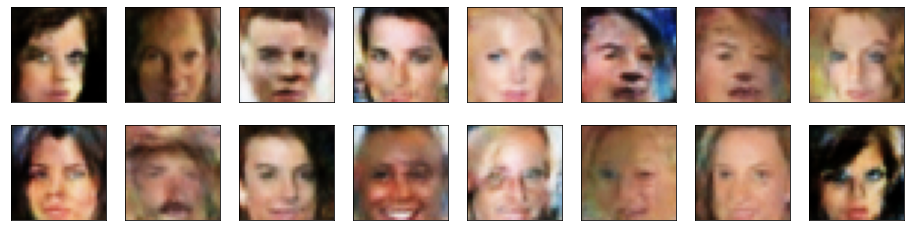

In [ ]:
# Load samples from generator taken while training
with open('train_G_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

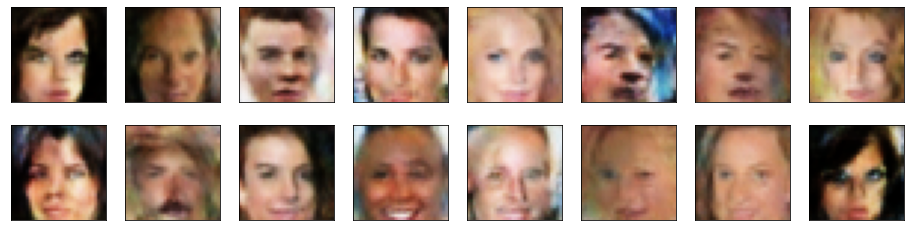

In [ ]:
# Load samples from encoder taken while training
with open('train_E_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

# Reconstruction on randomly generated data

In [ ]:
np.random.seed(50)
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
# move z to GPU if available
if use_cuda and torch.cuda.is_available():
    fixed_z = fixed_z.cuda()

x_n = G(fixed_z)    
fixed_G_sample.append(x_n)

z_n = E(x_n)
x_rec = G(z_n)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generator


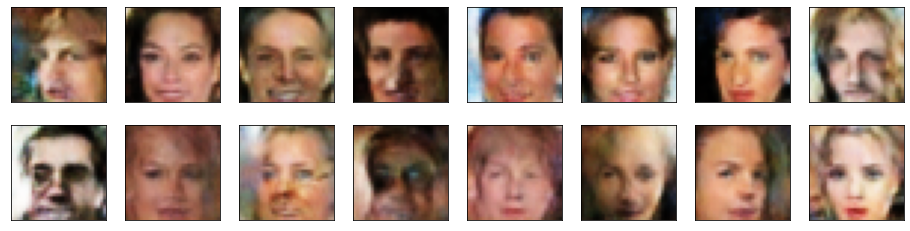

In [ ]:
print('Generator')
view_samples(-1, [x_n])

Reconstruction


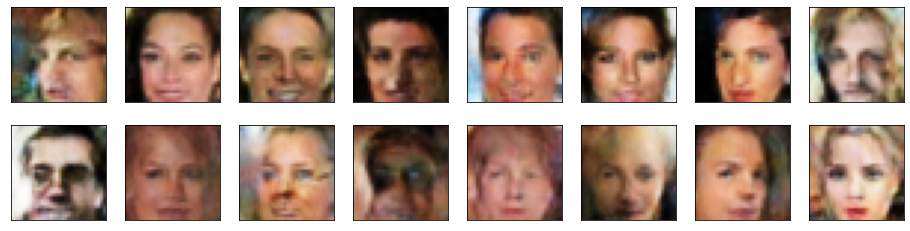

In [ ]:
print('Reconstruction')
view_samples(-1, [x_rec])

# Reconstruction of images from celeabA dataset

In [ ]:
dataset_url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip"
download_url(dataset_url, '.')
!unzip "/content/processed-celeba-small.zip" -d .

dataroot='/content/processed_celeba_small'

dataset=datasets.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(32),
        # transforms.Resize(64),
        transforms.CenterCrop(32),
        # transforms.CenterCrop(64),
        transforms.ToTensor()
        ])
        )

dataloader=DataLoader(dataset,num_workers=0,batch_size=16,shuffle=True)

Using downloaded and verified file: ./processed-celeba-small.zip
Archive:  /content/processed-celeba-small.zip
replace ./processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Generator
Reconstruction


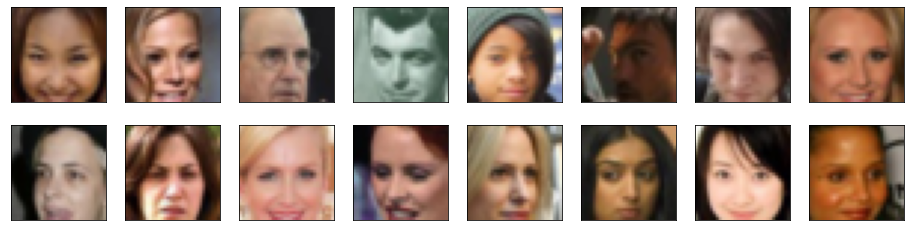

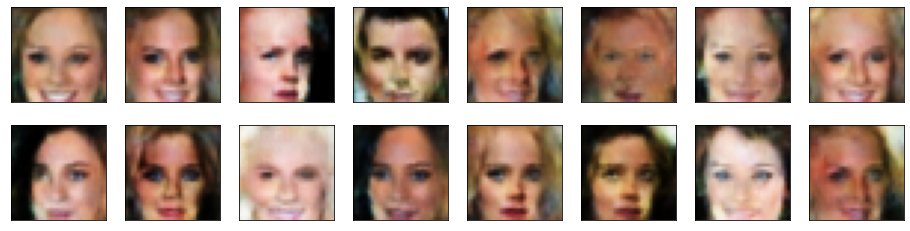

In [ ]:
def scale(img):
    img=img*2-1
    return img

for batch_i, (real_images, _) in enumerate(dataloader):
  batch_size = real_images.size(0)
  real_images = scale(real_images)
  if use_cuda and torch.cuda.is_available():
    real_images = real_images.cuda()

  z_n = E(real_images)
  x_rec = G(z_n)

  print('Generator')
  view_samples(-1, [real_images])
  
  print('Reconstruction')
  view_samples(-1, [x_rec]) 
  break

# Free up Cuda Memeory

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  6% |  1% |


# Random Stuff

In [ ]:
np.random.seed(0) ; 
print( np.random.rand(4) )
# np.random.seed(0) ; 
print( np.random.rand(4) )

[0.5488135  0.71518937 0.60276338 0.54488318]
[0.4236548  0.64589411 0.43758721 0.891773  ]


In [ ]:
z = np.random.uniform(-1, 1, size=(batch_size, z_size))

In [ ]:
z.shape

(16, 100)